In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

from openmovement.load import CwaData

In [29]:
def extract_data(filename):
    with CwaData(filename, include_gyro=True, include_temperature=True) as cwa_data:
        # As an ndarray of [time,accel_x,accel_y,accel_z,temperature]
        sample_values = cwa_data.get_sample_values()
        space_values = sample_values[:, 1:4]
        norms = np.linalg.norm(space_values, axis=1)
        space_values = np.column_stack((space_values, norms))
        time_index = sample_values[:, 0]
        
        # As a pandas DataFrame
        samples = cwa_data.get_samples()

    return {
        'filename': filename,
        'space_values': space_values,
        'time_index': time_index,
        'df': samples
    }

def extract_patient(pt_number):
    # load the data
    non_paretic = extract_data(f'data/ReArm_{pt_number}_ac_np.cwa')
    paretic = extract_data(f'data/ReArm_{pt_number}_ac_p.cwa')

    # remove the beginning of the earlier dataset to make the start times match
    start = max(non_paretic['time_index'][0], paretic['time_index'][0])

    non_paretic['space_values'] = non_paretic['space_values'][non_paretic['time_index'] >= start]
    non_paretic['time_index'] = non_paretic['time_index'][non_paretic['time_index'] >= start]

    paretic['space_values'] = paretic['space_values'][paretic['time_index'] >= start]
    paretic['time_index'] = paretic['time_index'][paretic['time_index'] >= start]

    # remove the end of the longer dataset to make the lengths match
    length = min(non_paretic['time_index'].shape[0], paretic['time_index'].shape[0])
    
    non_paretic['space_values'] = non_paretic['space_values'][:length]
    non_paretic['time_index'] = non_paretic['time_index'][:length]

    paretic['space_values'] = paretic['space_values'][:length]
    paretic['time_index'] = paretic['time_index'][:length]

    # define the time index
    time_index = (non_paretic['time_index'] + paretic['time_index']) / 2
    # the norms to a single array
    norms = np.column_stack((non_paretic['space_values'][:, 3], paretic['space_values'][:, 3]))

    # remove gravity
    norms = norms - 1

    return norms, time_index

In [30]:
norms, time_index = extract_patient("C1P08_20210810_1")

In [33]:
norms.shape

(32669316, 2)

/Users/victor/Documents/GitHub/rearm-actimetry-exploring/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


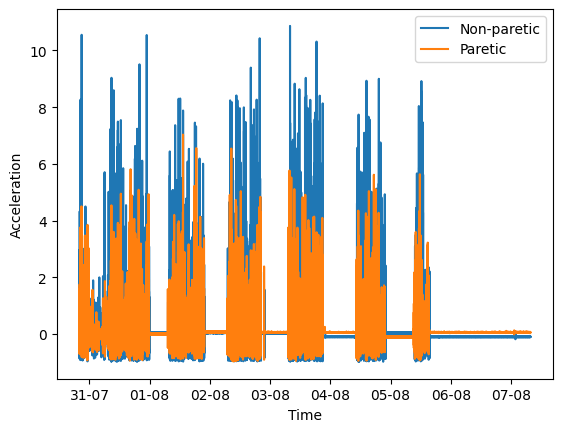

In [133]:
# plot the data
plt.plot(pd.to_datetime(time_index, unit='s'), norms)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.legend(['Non-paretic', 'Paretic'])
plt.show()

In [54]:
def partition(norms, time_index, minutes_window=5):
    delta_t = float(np.diff(time_index).mean())

    # partition the data into windows
    window_size = int(minutes_window * 60 / delta_t)
    num_windows = norms.shape[0] // window_size

    print(f"delta_t: {delta_t}")
    print(f"window_size: {window_size}")
    print(f"num_windows: {num_windows}")

    norms = norms[:num_windows * window_size]
    norms = norms.reshape((num_windows, window_size, norms.shape[1]))

    time_index = time_index[:num_windows * window_size]
    time_index = time_index.reshape((num_windows, window_size))
    #time_index = time_index.mean(axis=1)

    return norms, time_index
    # remove windows at the end with small standard deviation
    stds = norms.std(axis=1)    

In [55]:
windows, time_indexes = partition(norms, time_index)
windows.shape

delta_t: 0.019807240904446525
window_size: 15145
num_windows: 2157


(2157, 15145, 2)

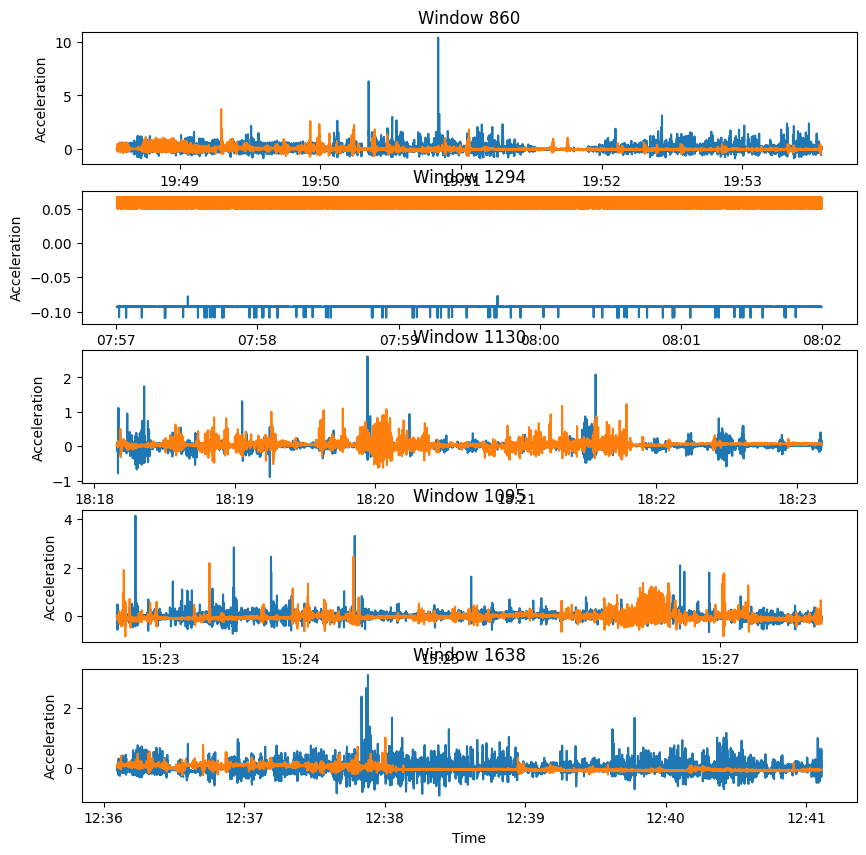

In [62]:
# plot 5 random windows
np.random.seed(42)
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i in range(5):
    idx = np.random.randint(0, windows.shape[0])
    axs[i].plot(pd.to_datetime(time_indexes[idx], unit='s'), windows[idx])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Acceleration')
    axs[i].title.set_text(f"Window {idx}")
    axs[i].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

plt.show()

In [75]:
def extract_features(window):
    # mean
    mean = window.mean(axis=0)

    # std
    std = window.std(axis=0)        
    
    return np.concatenate((mean, std))

In [78]:
features = np.array([extract_features(window) for window in windows])
features.shape

(2157, 4)

In [127]:
# ECM clustering
from evclust.ecm import ecm
model = ecm(x=features, c=3, beta = 1.3,  alpha=1, delta=3, disp=False)

In [128]:
F = model['F']
focal_sets = ["\\{"+", ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1])+"\\}" for f in F]
focal_sets[0] = "\emptyset"
focal_sets = ['$m_{'+f+'}$' for f in focal_sets]

mass = model['mass']

In [129]:
# get list of colors 
cmap = plt.get_cmap('Pastel1')
focal_colors = [np.array(cmap(i)) for i in range(len(focal_sets))]
colors = []
for point in range(len(features)):
    color = np.sum([focal_colors[i] * mass[point, i] for i in range(len(focal_sets))], axis=0)
    color = np.clip(color, 0, 1)
    color = color[:3]
    colors.append(color)

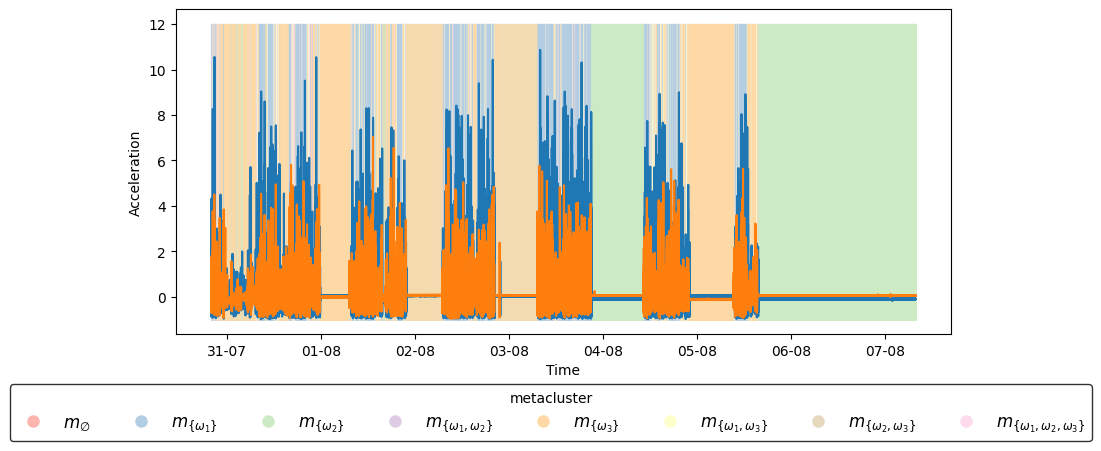

In [136]:
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(len(time_indexes)):
    ax.fill_between(pd.to_datetime(time_indexes[i], unit='s'), -1, 12, color=colors[i])

# plot the data
ax.plot(pd.to_datetime(time_index, unit='s'), norms)

ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))

fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=focal_sets[i], 
                               markerfacecolor=cmap(i), markersize=10) for i in range(len(focal_sets))], edgecolor='black', 
                               loc='lower center', ncol=len(focal_sets), fontsize='large', title='metacluster', bbox_to_anchor=(0.5, 0))

fig.subplots_adjust(bottom=0.23)